# MNISQ VQC — Blind Quantum Computing

Este notebook demonstra como treinar um modelo de Rede Neural Quântica (VQC)
usando o Qiskit Machine Learning e circuitos gerados a partir de arquivos QASM
da base MNIST.


In [16]:
#Instale as dependências
!pip install qiskit qiskit-aer qiskit-machine-learning qiskit-algorithms scikit-learn matplotlib numpy


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Dreysv\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [17]:
# Imports e configurações iniciais
import os
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss
from qiskit_algorithms.optimizers import COBYLA

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

%matplotlib inline


# Controle de Aleatoriedade e Reprodutibilidade

In [18]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

try:
    from qiskit_algorithms.utils import algorithm_globals
    algorithm_globals.random_seed = SEED
except Exception as e:
    print("Não foi possível configurar a semente global do Qiskit, continuando...", str(e))


# Callback: envio do circuito por época

In [19]:
def enviar_circuito_por_epoca(circuito, epoch, num_qubits, circuit_depth):
    print(f"[Epoch {epoch+1}] Enviando circuito para a rede (stub)...")
    try:
        rede.application_layer.run_app(
            "BFK_BQC",
            alice_id=6,
            bob_id=0,
            num_qubits=num_qubits,
            scenario=2,
            circuit_depth=circuit_depth,
            circuit=circuito
        )
        print(f"Circuit depth: {circuit_depth}, num_qubits: {num_qubits}")
    except Exception as e:
        print(f"[Epoch {epoch+1}] Erro ao enviar circuito: {str(e)}")


# Funções

In [20]:

def show_figure(pict: np.array, index=0, fidelity=None):
    plt.imshow(pict.reshape(28, 28), cmap="Greys")
    plt.axis('off')
    title = f"Imagem {index}"
    if fidelity is not None:
        title += f" - Fidelidade: {fidelity:.6f}"
    plt.title(f"Imagem {index}")
    plt.show()
    plt.close()

def show_state_figure(state, index=0, fidelity=None):
    state_np = np.array(state)
    pict = np.abs(state_np[:784])
    show_figure(pict, index=index, fidelity=fidelity)

def mostrar_matriz_confusao(y_true, y_pred, classes=None, title='Matriz de Confusão'):
    """
    Calcula e mostra a matriz de confusão formatada
    """
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n{title}")
    print("=" * 30)
    
    if classes is None:
        classes = [f'Classe {i}' for i in range(len(cm))]
    
    # Cabeçalho
    header = "         " + " ".join(f"{cls:>8}" for cls in classes)
    print(header)
    print(" " * 9 + "-" * (len(classes) * 9))
    
    # Linhas da matriz
    for i, row in enumerate(cm):
        row_str = f"{classes[i]:<8} |"
        for val in row:
            row_str += f" {val:>7}"
        print(row_str)
    
    return cm

def mostrar_matriz_confusao_normalizada(y_true, y_pred, classes=None, title='Matriz de Confusão Normalizada'):
    """
    Calcula e mostra a matriz de confusão normalizada
    """
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    print(f"\n{title}")
    print("=" * 40)
    
    if classes is None:
        classes = [f'Classe {i}' for i in range(len(cm))]
    
    # Cabeçalho
    header = "         " + " ".join(f"{cls:>10}" for cls in classes)
    print(header)
    print(" " * 9 + "-" * (len(classes) * 11))
    
    # Linhas da matriz
    for i, row in enumerate(cm_norm):
        row_str = f"{classes[i]:<8} |"
        for val in row:
            row_str += f" {val:>9.3f}"
        print(row_str)
    
    return cm_norm

# Inicializar o Backend com Ruído

In [21]:

noise_model = NoiseModel()
error_1q = depolarizing_error(0.01, 1)  
error_2q = depolarizing_error(0.02, 2) 

noise_model.add_all_qubit_quantum_error(error_1q, ['h', 'x', 'y', 'z', 'rx', 'ry', 'rz', 's', 'sdg', 't', 'tdg'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx', 'cz', 'swap'])

simulator = AerSimulator(
    noise_model=noise_model,
    shots=1024,
    method='statevector'
)
# simulator = AerSimulator(method='statevector') #sem ruído

print('Simulador configurado:', simulator)


Simulador configurado: AerSimulator('aer_simulator_statevector'
             noise_model=<NoiseModel on ['s', 'sdg', 'h', 'x', 'rx', 'rz', 'cz', 'swap', 'cx', 'ry', 't', 'y', 'tdg', 'z']>)


# Carregar os arquivos QASM da base MNIST.

In [22]:
from qiskit.quantum_info import state_fidelity, Statevector
path = "base_test_mnist_784_f90/qasm/"

file_list = sorted(os.listdir(path))[:20] # pega os 20 primeiros arquivos para exemplo

states = []
labels = []

for i, file_name in enumerate(file_list):
    try:
        full_path = os.path.join(path, file_name)
        with open(full_path) as f:
            qasm = f.read()
            qc = QuantumCircuit.from_qasm_str(qasm)
            qc.save_statevector()
            compiled = transpile(qc, simulator)
            job = simulator.run(compiled)
            result = job.result()
            try:
                state = result.data(0)['statevector']
                state_sv = Statevector(state)
                reference_state = np.zeros(state.dim, dtype=complex)
                reference_state[0] = 1.0
                fidelity = state_fidelity(state_sv, reference_state)
                #show_state_figure(state_sv, index=i, fidelity=fidelity) #representação da iamgem
                print(f"Fidelidade da imagem {i}: {fidelity:.6f}") 
            except Exception:
                state = result.get_statevector(compiled)
            features = np.abs(state)
            features = features[:4] # reduz para 4 características (exemplo)
            states.append(features)
            labels.append(0 if i < 10 else 1)  # rótulo de exemplo: primeiros 10 -> classe 0, resto -> classe 1
    except Exception as e:
        print(f"Erro ao processar {file_name}: {str(e)}")

X = np.array(states)
y = np.array(labels)

if len(X) == 0:
    raise ValueError("Nenhum dado foi carregado corretamente! Verifique os arquivos QASM e o simulador.")
else:
    print(f"Dados carregados: X.shape={X.shape}, y.shape={y.shape}")


Fidelidade da imagem 0: 0.000198
Fidelidade da imagem 1: 0.000913
Fidelidade da imagem 2: 0.000199
Fidelidade da imagem 3: 0.001524
Fidelidade da imagem 4: 0.001016
Fidelidade da imagem 5: 0.001039
Fidelidade da imagem 6: 0.000005
Fidelidade da imagem 7: 0.000128
Fidelidade da imagem 8: 0.000024
Fidelidade da imagem 9: 0.000486
Fidelidade da imagem 10: 0.002979
Fidelidade da imagem 11: 0.000647
Fidelidade da imagem 12: 0.000128
Fidelidade da imagem 13: 0.000007
Fidelidade da imagem 14: 0.001752
Fidelidade da imagem 15: 0.000420
Fidelidade da imagem 16: 0.017235
Fidelidade da imagem 17: 0.001162
Fidelidade da imagem 18: 0.000045
Fidelidade da imagem 19: 0.000150
Dados carregados: X.shape=(20, 4), y.shape=(20,)


# Normalização e divisão dos dados

In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

num_qubits = X.shape[1]
print(f"Num qubits (features) = {num_qubits}")


Num qubits (features) = 4


# Cria o circuito quântico (FeatureMap + Ansatz)

In [24]:
# Construção do feature map e ansatz
feature_map = ZZFeatureMap(num_qubits, reps=10, entanglement="full")
ansatz = RealAmplitudes(num_qubits, reps=10, entanglement="full")

qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

print('Circuito pronto. Depth aproximado:', qc.depth())


Circuito pronto. Depth aproximado: 2


# EstimatorQNN 

In [25]:
estimator = Estimator(options={
    "backend": simulator,
    "resilience_level": 1,
    "approximation": True
})

qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
    input_gradients=True
)

vqc = NeuralNetworkClassifier(
    neural_network=qnn,
    loss=CrossEntropyLoss(),
    optimizer=COBYLA(maxiter=50),
    warm_start=True,
    callback=lambda weights, loss, step: enviar_circuito_por_epoca(
        circuito=feature_map.compose(ansatz.assign_parameters(weights)),
        epoch=step,
        num_qubits=num_qubits,
        circuit_depth=feature_map.compose(ansatz).depth()
    )
)

print('VQC (NeuralNetworkClassifier) configurado.')


VQC (NeuralNetworkClassifier) configurado.


C:\Users\Dreysv\AppData\Local\Temp\ipykernel_12556\3632900870.py:1: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={
C:\Users\Dreysv\AppData\Local\Temp\ipykernel_12556\3632900870.py:7: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


# Treinamento

In [26]:

print("\nTREINANDO VQC...\n")
vqc.fit(X_train, y_train)
print("Treinamento concluído.")


TREINANDO VQC...

Treinamento concluído.


# Avaliação: métricas

In [27]:

print("\nCALCULANDO MÉTRICAS...\n")
y_pred = vqc.predict(X_test)

# Ajustes para formato binário
y_pred = np.round(y_pred).astype(int)
y_pred = np.clip(y_pred, 0, 1)

# CALCULAR MATRIZ DE CONFUSÃO
print("\n" + "="*50)
print("MATRIZ DE CONFUSÃO")
print("="*50)

cm = mostrar_matriz_confusao(y_test, y_pred, classes=['Classe 0', 'Classe 1'], title='Matriz de Confusão - VQC Quântico')

cm_norm = mostrar_matriz_confusao_normalizada(y_test, y_pred, classes=['Classe 0', 'Classe 1'], 
                              title='Matriz de Confusão Normalizada - VQC Quântico')
tn, fp, fn, tp = cm.ravel()

print(f"\nDetalhamento da Matriz de Confusão:")
print(f"Verdadeiros Negativos (TN): {tn}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Falsos Negativos (FN): {fn}")
print(f"Verdadeiros Positivos (TP): {tp}")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

print("\nMÉTRICAS FINAIS:")
print(f"Acurácia : {accuracy:.4f}")
print(f"Precisão : {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

print("\nResultados Detalhados:")
print("Entradas:\n", X_test)
print("Saídas Previstas:\n", y_pred)
print("Saídas Reais:\n", y_test)




CALCULANDO MÉTRICAS...


MATRIZ DE CONFUSÃO

Matriz de Confusão - VQC Quântico
         Classe 0 Classe 1
         ------------------
Classe 0 |       1       1
Classe 1 |       1       1

Matriz de Confusão Normalizada - VQC Quântico
           Classe 0   Classe 1
         ----------------------
Classe 0 |     0.500     0.500
Classe 1 |     0.500     0.500

Detalhamento da Matriz de Confusão:
Verdadeiros Negativos (TN): 1
Falsos Positivos (FP): 1
Falsos Negativos (FN): 1
Verdadeiros Positivos (TP): 1

MÉTRICAS FINAIS:
Acurácia : 0.5000
Precisão : 0.5000
Recall   : 0.5000
F1 Score : 0.5000

Resultados Detalhados:
Entradas:
 [[0.         0.         0.47868667 0.47774948]
 [0.28564818 0.80908288 0.53954177 0.18398535]
 [0.07101951 0.6233981  0.49682453 0.23878475]
 [1.         0.66188669 0.33792306 0.28807314]]
Saídas Previstas:
 [[1]
 [0]
 [1]
 [0]]
Saídas Reais:
 [0 0 1 1]


# Gráfico

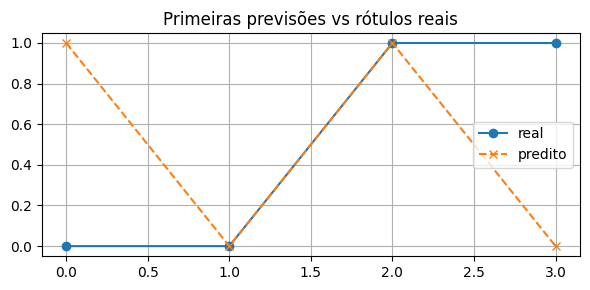

In [28]:
plt.figure(figsize=(6,3))
plt.title('Primeiras previsões vs rótulos reais')
plt.plot(y_test, marker='o', label='real')
plt.plot(y_pred, marker='x', linestyle='--', label='predito')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()